# Exploration of the textual dataset with labels integration


Dans ce notebook, on se propose d'intégrer les classes à prédire du jeu de données d'entraînement `Y_train.csv`, que l'on nommera `labels` au dataset d'entraînement `X_train.csv` utilisé et exploré dans le notebook `discovery-text-1.ipynb`. On notera ce dernier `data`.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 1 - Preparation of the dataset

Avant d'explorer le dataset complet, il doit être préparé. On va reconstruire les colonnes créées dans le notebook `exploration-text-1.ipynb`, à savoir les colonnes qui dénombrent les tailles des titres et descriptions des produits. Les colonnes `productid` et `imageid` seront retirées (elles seront utiles pour une exploration liées aux images) et `labels` et `data` seront rattachés pour former le dataset global `df`.


In [2]:
data = pd.read_csv('../../data/X_train.csv', index_col=0).drop(columns=['productid', 'imageid'])

data['designation_length'] = data['designation'].apply(lambda s: len(s))
data['description_length'] = data['description'].apply(lambda s: len(s) if isinstance(s, str) else 0)

labels = pd.read_csv('../../data/Y_train.csv', index_col=0)

df = pd.concat([data, labels], axis=1)

display(df.info())
display(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   designation         84916 non-null  object
 1   description         55116 non-null  object
 2   designation_length  84916 non-null  int64 
 3   description_length  84916 non-null  int64 
 4   prdtypecode         84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


None

,designation,description,designation_length,description_length,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,88,0,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,206,0,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,76,760,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,63,0,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,20,213,2705


On a maintenant un dataset prêt à être explorer.


## 2 - Labels

On va extraire des informations essentielles sur les différentes classes pour assurer un prétraitement pertinent. Cela inclut notamment le nombre de classes, la répartition des données dans les classes, les relations des features avec les classes. Renommons d'abord la colonne des labels.


In [3]:
df = df.rename(columns={'prdtypecode': 'labels'})


### 2.1 - Statistics

On détermine les statistiques de base concernant les labels.


In [4]:
print(f"Number of classes : {df['labels'].nunique()}")
print(f"Values of labels : {df['labels'].unique()}")


Number of classes : 27
Values of labels : [  10 2280   50 1280 2705 2522 2582 1560 1281 1920 2403 1140 2583 1180
 1300 2462 1160 2060   40   60 1320 1302 2220 2905 2585 1940 1301]


On a donc $27$ classes différentes, c'est donc un problème de classification qui ne peut pas être considéré comme un problème de petite dimension. Analysons la distribution des classes au sein des données.


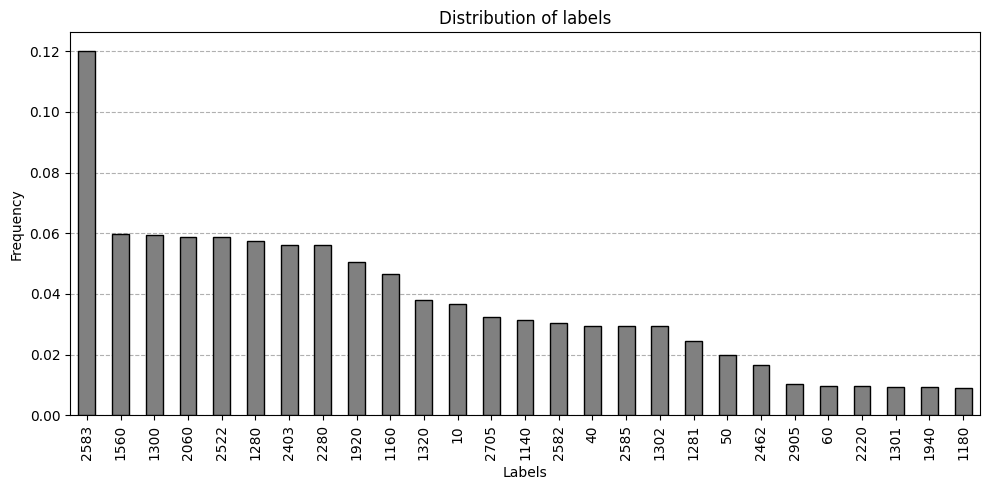

In [5]:
labels_repartition = df['labels'].value_counts(normalize=True)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

labels_repartition.plot(kind='bar', color='gray', edgecolor='black', ax=ax, zorder=3)

ax.set_title('Distribution of labels')
ax.set_xlabel('Labels')
ax.set_ylabel('Frequency')
ax.grid(visible=True, linestyle='--', axis='y', zorder=0)

plt.tight_layout()

plt.show()


On note immédiatement que la distribution des classes est sensiblement hétérogène, avec notamment le label $2583$ qui est sur-représenté au sein des données tandis que d'autres sont sous-représentés. Il en résulte qu'un ré-échantillonnage des données est nécessaire pour améliorer le pouvoir prédictif des futures modèles. On peut penser notamment à :
- L'under-sampling des labels sur-représentés (le jeu de données reste très volumineux)
- L'over-sampling des labels sous-représentés (conserve toute la richesse du jeu de données)


### 2.2 Advanced analysis

Pour définir les techniques utilisées, il peut être intéressant de mettre en évidence la qualité des données disponibles pour chaque classe. En particulier, il est judicieux d'identifier si certaines classes ont une plus grande proportion de valeurs manquantes (colonne `description`). Suite aux analyses du notebook `exploration-text-1.ipynb`, on va aussi déterminer la taille moyenne des titres pour chaque classe, qui pourra affiner l'analyse (on rappelle que des titres *longs* pourront être considérés comme des descriptions).


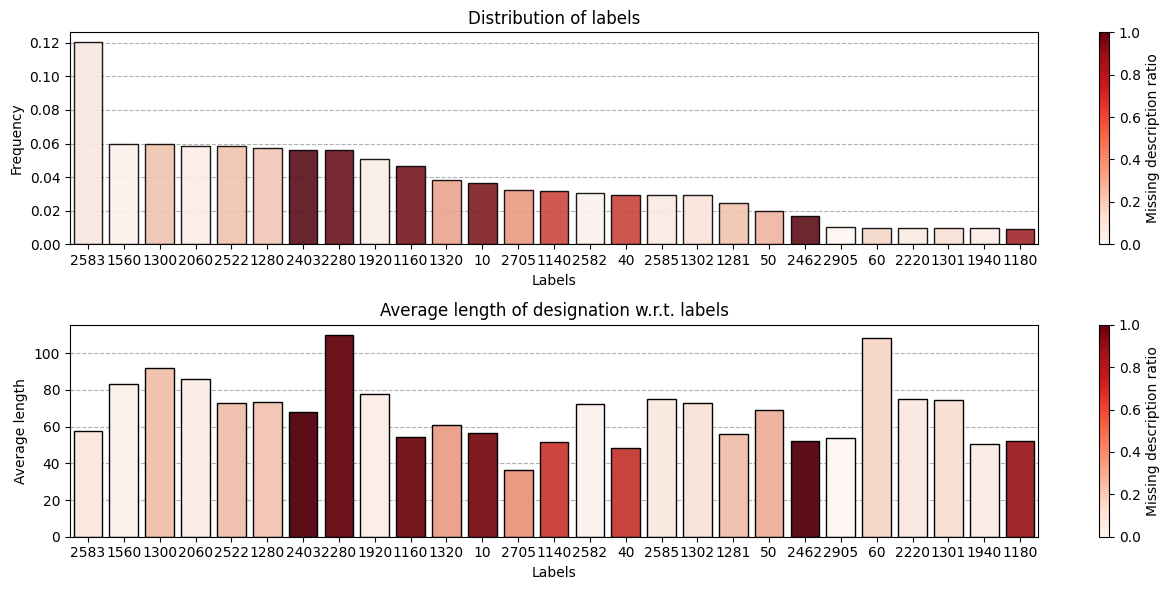

In [6]:
df['missing_description'] = df['description'].isna().astype('int')

for_agg = {'label_count': pd.NamedAgg(column='labels', aggfunc='count'),
           'missing_count': pd.NamedAgg(column='missing_description', aggfunc='sum'),
           'avg_designation_length': pd.NamedAgg(column='designation_length', aggfunc='mean')}

labels_aggs = df[['designation_length', 'missing_description', 'labels']].groupby(['labels']).agg(**for_agg)
labels_aggs['label_freq'] = labels_aggs['label_count'] / df.shape[0]
labels_aggs['missing_ratio'] = labels_aggs['missing_count'] / labels_aggs['label_count']

sorted_labels_freqs = labels_aggs.sort_values(by='label_freq', ascending=False)[['label_freq', 'missing_ratio', 'avg_designation_length']]
x = sorted_labels_freqs.index.astype('str')


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 6))

sns.barplot(data=sorted_labels_freqs, x=x, y=sorted_labels_freqs['label_freq'], hue='missing_ratio', palette='Reds', edgecolor='black', zorder=2, alpha=0.9, ax=ax[0])
sns.barplot(data=sorted_labels_freqs, x=x, y=sorted_labels_freqs['avg_designation_length'], hue='missing_ratio', palette='Reds', edgecolor='black', zorder=2, ax=ax[1])

ax[0].set_title('Distribution of labels')
ax[0].set_xlabel('Labels')
ax[0].set_ylabel('Frequency')
ax[0].grid(visible=True, linestyle='--', axis='y', zorder=0)
ax[0].legend().remove()
sm = plt.cm.ScalarMappable(cmap='Reds')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0])
cbar.set_label('Missing description ratio')

ax[1].set_title('Average length of designation w.r.t. labels')
ax[1].set_xlabel('Labels')
ax[1].set_ylabel('Average length')
ax[1].grid(visible=True, linestyle='--', axis='y', zorder=0)
ax[1].legend().remove()
sm = plt.cm.ScalarMappable(cmap='Reds')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1])
cbar.set_label('Missing description ratio')

plt.tight_layout()

plt.show()


On note tout d'abord qu'il y a $8$ classes dont la proportion de descriptions manquantes est particulièrement élevée : les classes $2403$, $2280$, $1160$, $10$, $1140$, $40$, $2462$, et $1180$. A l'exception de la classe $2280$, les longueurs moyennes des titres pour ces classes ne permettent pas de conclure que les descriptions sont incluses dans les titres. Pour la classe $2280$, La longueur moyenne est considérablement plus élevée, ce qui peut s'expliquer soit par la présence des descriptions dans les titres, soit par la nature de la classe qui représenterait des produits dont les titres sont intrinsèquement plus long.

Notons qu'étant donné que ces $8$ classes ont une proportion de valeurs manquantes très élevée, il devient obligatoire de compléter la colonne `description` pour ne pas perdre d'information et voir certaines classes mal prédites par les modèles. L'idée de supprimer les valeurs manquantes est à abandonner tout comme l'idée d'exclure cette colonne. En effet, certaines classes ont une très bonne proportion de valeurs manquantes (faible à nulle), on perdrait alors des informations importantes pour appuyer les modèles dans la classification des produits.
